# Исследование по выявлению закономерностей определяющих успешность игры.

Открытие файлов данных, импорт библиотек, изучение общей информации

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random
from scipy import stats as st
import seaborn as sns

In [6]:
game_rating = pd.read_csv('/datasets/games.csv') 
game_rating.duplicated().sum()#проверил наличие полных дубликатов по строке
game_rating.columns#можно привести к одному регистру
game_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [7]:
game_rating.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Рассмотрим полученную информацию подробнее. Всего в таблице 11 столбцов и 16715 строк. 6 столбцов с вещественным типом данных и 5 обьектным.

Подробно разберём, какие в game_rating столбцы, и какую информацию они содержат:

Name — название игры Platform — платформа Year_of_Release — год выпуска Genre — жанр игры NA_sales — продажи в Северной Америке (миллионы долларов) EU_sales — продажи в Европе (миллионы долларов) JP_sales — продажи в Японии (миллионы долларов) Other_sales — продажи в других странах (миллионы долларов) Critic_Score — оценка критиков (максимум 100) User_Score — оценка пользователей (максимум 10) Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

есть пропуски в колонках Name, Year_of_Release, Critic_Score, User_Score и Rating
дату релиза лучше привести к целому числу, необязательно переводить её именно в dt. оценку пользователей лучше перевести в числовой формат. В описании есть упоминание, что данные за 2016 г могут быть неполными. Это нужно учесть, например, при выборе перспективных платформ.

# Подготовка данных

Поиск и обработка пропущенных значений. Нужно сразу определиться, что почти все пропуски теоретически возможно востановить используя информацию о данных играх из интернета. Но я исходил из того , что я это могу сделать только в ручную и автоматизировать эту работу пока не могу. В связи с этим буду использовать, то что есть. Думаю, что почти все пропуски это ошибки выгрузки или банальное отсутствие части информации по игре в источниках от куда она бралась.

Заменил названия столбцов

In [8]:
game_rating.columns = game_rating.columns.str.lower()#привел к нижнему регистру названия столбцов

In [9]:
game_rating[game_rating['name'].isnull()]
#пропуски в названии и в жанре. Проще удалить, данных для их востановления недостаточно.
game_rating.drop([659, 14244], inplace = True)

Пропуски в дате релиза


часть их точно можно восстановить, ведь в названиях многих игр используется год релиза. Хотя не всегда это так, год релиза может
отличаться от года в названии. В таблице есть такие примеры. 
а также можно исходить из платформ. Игры выходят на разных платформах. У одной и той же игры значения даты релиза на одной платформе есть, а на другой отсутвует. Хотя даты релиза на разных платформах могут различаться, но для примера я заполнил пропущенные значения датами релиза с других платформ.

In [10]:
game_rating['year_of_release'] = game_rating['year_of_release'].fillna(-1).astype('int')
#заполнил пропуски нестандартными значениями

In [11]:
fill = game_rating[game_rating['year_of_release'] == -1]['name'].str.extract('(\d+)').fillna(-1).astype('int')
#выбрал даты из названий игр

In [12]:
fill = fill[fill[0] > 1970]#иначе выдавал нестандартные значения

In [13]:
game_rating = game_rating.join(fill, how='left')#позже заменю пропуски year_of_release значениями из этого столбца

In [14]:
#заполнение пропусков по данным релиза с других платформ.
name_unique  = game_rating[game_rating['year_of_release'] == -1]['name'].unique()
#уникальные названия игр у которых есть пропуски в дате релиза

for i in name_unique:
    #цикл для заполнения пропусков по каждому уникальному значению
    name_dubl = game_rating.groupby(game_rating['name'] == i).agg({'year_of_release':'max'}).loc[1,'year_of_release']
    game_rating.loc[game_rating['name'] == i, 'year_of_release']\
    = game_rating.loc[game_rating['name'] == i, 'year_of_release'].replace(-1,name_dubl)
    #заполнение пропущенных значений в столбце year_of_release максимальным значением c помощью логической индексации

Идея в том, что зная время существования платформы, заполнить пропуски в датах релиза. Например, было 3 платформы, существовавших всего год. Соответственно, все свои игры они выпустили в этот год. Но в этих трех платформах пропусков нет. Или вариант с заполнением пропуска последним годом существования платформы.

In [15]:
#заменил пропуски на даты с помощью функции
def func_year(row):
    if row['year_of_release'] == -1 and row['platform'] == "2600":#ещё минус 16 пропусков
        return 1989
    if row['year_of_release'] == -1 and row[0] != "NaN": #использовал столбец 0 (с датами из названий)
        return row[0]
    return row['year_of_release']
game_rating['year_of_release'] = game_rating.apply(func_year, axis=1)
game_rating.drop([0], axis =1, inplace = True)#удалил столбец 0


In [16]:
game_rating['year_of_release'] = game_rating['year_of_release'].fillna(-1).astype('int')
#количество пропусков сократилось с 269 до 123.
#оставшиеся заменены на нестандартные значения, в дальнейшем при анализе буду их игнорировать

In [17]:
#game_rating[game_rating['year_of_release'] != -1].groupby(['platform'])['year_of_release'].count()
#game_rating['year_of_release'].value_counts()

Пропусков в продажах нет, но есть нулевые значения, в том числе и по всем регионам сразу. Таких игры две. index 16676 и 16709

Пропуски в оценках критиков и пользователей.
Хороших вариантов для заполнения пропусков я не нашел. Заменю на нестандартные значения и не буду их учитывать при анализе.
Что касается значений tbd - это значит , что для определения оценки пользователей по данной игре не хватило количества отзывов.
Значит, эти оценки не стоит учитывать.

In [18]:
game_rating[['critic_score','user_score']] = game_rating[['critic_score','user_score']].fillna(-1)
game_rating['user_score'] = game_rating['user_score'].replace('tbd', -1)#заменил значения tbd на -1 , для удобства.
game_rating['user_score'] = game_rating['user_score'].astype('float64')

Пропуски в рейтинге ESRB. Начнем с того , что основана организация, выставляющая рейтинги, была в 1994г. Соответственно, рейтингов у игр раньше 1994 нет, и это нормально. Таких игр 426.
Рейтинг K-A == E.
«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу. Таких всего 3.

Заменил все пропуски на нестандартные значения.

In [19]:
game_rating['rating'] = game_rating['rating'].fillna(-1)
game_rating['rating'] = game_rating['rating'].replace('K-A', 'E')# K-A тоже , что и  E
#game_rating.query('year_of_release <1994)[game_rating['rating'].isnull()]

Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец.

In [20]:
game_rating['sum_sales'] = game_rating['na_sales'] + game_rating['eu_sales'] +\
                                            game_rating['jp_sales'] + game_rating['other_sales']
game_rating['sum_sales'] = (game_rating['sum_sales']*1000) #перевел в тыс.$
game_rating['na_sales'] = (game_rating['na_sales']*1000)
game_rating['eu_sales'] = (game_rating['eu_sales']*1000)
game_rating['jp_sales'] = (game_rating['jp_sales']*1000)
game_rating['other_sales'] = (game_rating['other_sales']*1000)


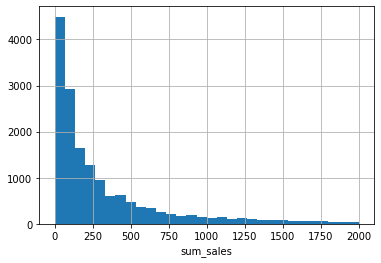

count    16713.000000
mean       533.314785
std       1548.282414
min          0.000000
25%         60.000000
50%        170.000000
75%        470.000000
max      82540.000000
Name: sum_sales, dtype: float64


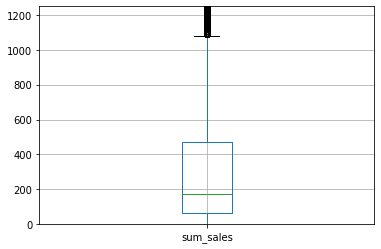

In [21]:
game_rating['sum_sales'].hist(bins = 30,range = (0,2000))
plt.xlabel("sum_sales")
plt.show()
print(game_rating['sum_sales'].describe())
game_rating.boxplot(column = 'sum_sales')
plt.ylim(0,1250)
plt.show()

# Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?


Text(0, 0.5, 'count')

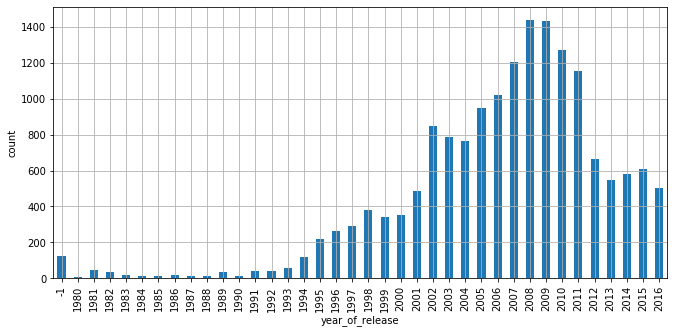

In [22]:
game_rating['index_game'] = range(len(game_rating))
game_rating.groupby(['year_of_release'])['sum_sales'].count()\
                                                 .plot.bar(grid=True, figsize=(11,5))
plt.ylabel("count")

Опираясь только на количество выпускаемых игр по годам, можно сказать, что данные с 1994 и ниже не так важны. По причине совсем небольшого выпуска игр в год. 

Посмотрим, как менялись продажи по платформам. Виберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Text(0, 0.5, 'sum_sales')

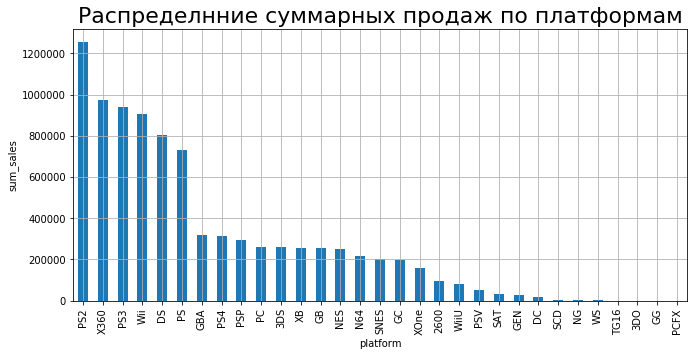

In [65]:
top_platform = game_rating.groupby(['platform',])['sum_sales'].sum().sort_values(ascending = False).reset_index().head(6)
game_rating.groupby(['platform'])['sum_sales'].sum().sort_values(ascending = False)\
                            .plot.bar(grid=True, figsize=(11,5))

plt.title("Распределнние суммарных продаж по платформам", fontsize=22)
plt.ylabel("sum_sales")

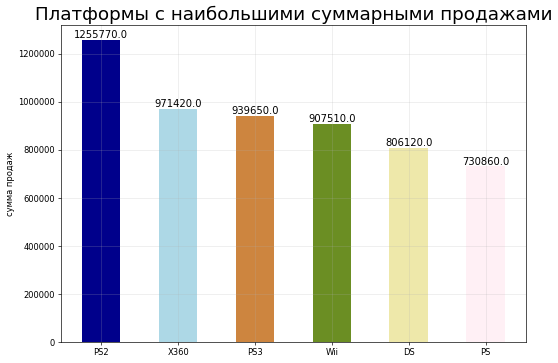

In [74]:
import random
n = top_platform['platform'].__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

plt.figure(figsize=(10,7), dpi= 60)
plt.bar(top_platform['platform'], top_platform['sum_sales'].round(1), color=c, width=.5)
for i, val in enumerate(top_platform['sum_sales'].round(1).values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.grid(axis='both', alpha=.3)
plt.title("Платформы с наибольшими суммарными продажами", fontsize=22)
plt.ylabel('сумма продаж')
plt.show()

Text(0, 0.5, 'sum_sales')

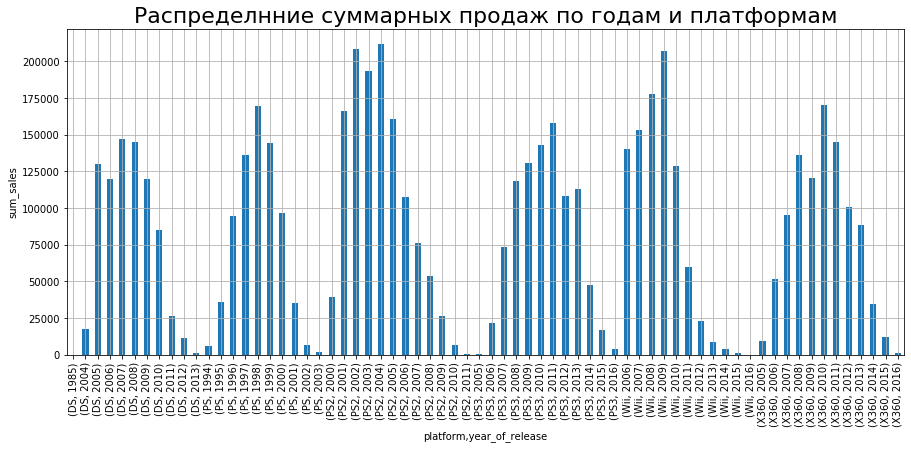

In [24]:

game_rating.query('platform == @top_platform and year_of_release > 1970')\
                .groupby(['platform','year_of_release'])['sum_sales']\
                                    .sum().plot.bar(grid=True, figsize=(15,6))

plt.title("Распределнние суммарных продаж по годам и платформам", fontsize=22)
plt.ylabel("sum_sales")

Выводы: Платформы существуют в среднем 11-12 лет. Каждые 5 - 8 лет основные производители платформ Microsoft, Sony, Nintendo выпускают новую версию игровой платформы. Это связано с появление новых технологий и возросшими требованиями игр. Особняком, конечно, стоит PS).

Возьмите данные которые помогут построить прогноз на 2017 год.

In [25]:
life_platform = game_rating.query('year_of_release >= 2015')['platform'].unique().tolist()
game_rating_actual = game_rating.query('platform == @life_platform and year_of_release >= 2013')
game_rating_actual.query('platform == @life_platform').groupby(['platform']).agg({'year_of_release':['min','max']})

year_of_release      
                     min   max
platform                      
3DS                 2013  2016
PC                  2013  2016
PS3                 2013  2016
PS4                 2013  2016
PSP                 2013  2015
PSV                 2013  2016
Wii                 2013  2016
WiiU                2013  2016
X360                2013  2016
XOne                2013  2016

Вывод:
Для определения популярных жанров нам бы подошли все года, хотя популярность жанров очень зависит от хитов в этих жанрах, и  за разные года их популярность меняется.
Для определения зависимости продаж от рейтинга ESRB, подошли бы все данные от 1994г, но история та же, что и с жанрами.
Для ответа на вопрос о растущих, падающих, потенциально прибыльных платформах, конечно, нужны действующие на момент анализа платформы. А поскольку данные на 2016г не полны, следует выбирать живые платформы, основываясь на year_of_release >= 2015.
Таковые платформы - 'PS4', 'XOne', '3DS', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV', 'PSP'. Касаемо PSP есть вопросы, у неё нет выпущенных игр в 2016г, а в 2015 было всего 3 игры, с минимальной прибылью. 
Поэтому предлагаю актуальным периодом считать данные с 2013 года, (это дата выпуска первой из живых платформ) и включать в них только живые платформы.

Определим какие платформы лидируют по продажам, растут или падают? Выбирем несколько потенциально прибыльных платформ.

Text(0, 0.5, 'sum_sales')

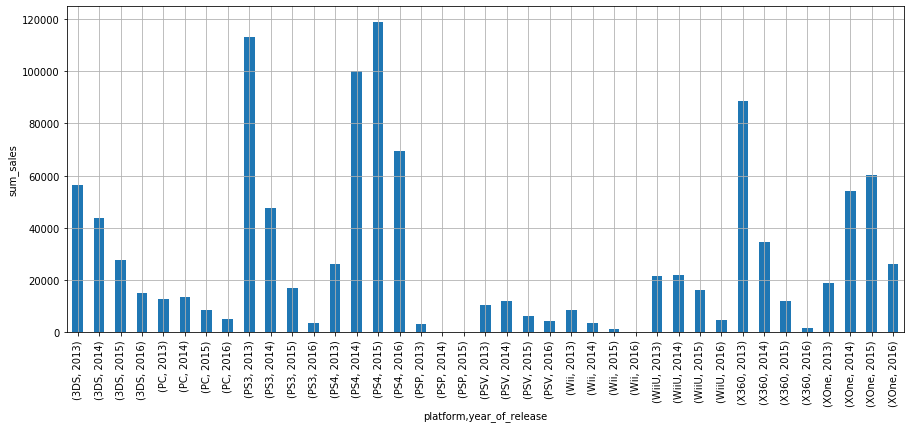

In [26]:
game_rating_actual.groupby(['platform','year_of_release'])['sum_sales']\
                                    .sum().plot.bar(grid=True, figsize=(15,6))
plt.ylabel("sum_sales")

Вывод: Потенциально прибыльными платформами являются - почти весь наш список 'PS4', 'XOne', '3DS', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV', за исключением, пожалуй, PSP - по причинам указанным мной выше. Во всех платформах кроме 'PS4', 'XOne', продажи падают уже несколько лет. Так же PS3, WII, X360 и снова PSP находятся на "излете своей жизни", и у них уже есть замены от производителей. Про PC отдельный разговор - похоже больше пользователей предпочитают покупать игры на консолях(ведь игры, вышедшие на PC, выходят и на консолях). Но есть исключения - онлайн-игры, где пользователь платит не за покупку игры, а донатит в неё.

Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах?

platform             3DS     PC     PS3     PS4   PSP    PSV    Wii   WiiU  \
sum_sales sum     143250  40060  181430  314140  3740  32990  13660  64630   
          mean       472    208     525     801    55     92    593    562   
          median      90     80     150     200    20     40    180    200   
          max      14600   3050   21050   14629   240   1960   3579   7090   

platform            X360    XOne  
sum_sales sum     136800  159320  
          mean       735     645  
          median     265     220  
          max      16270    7389

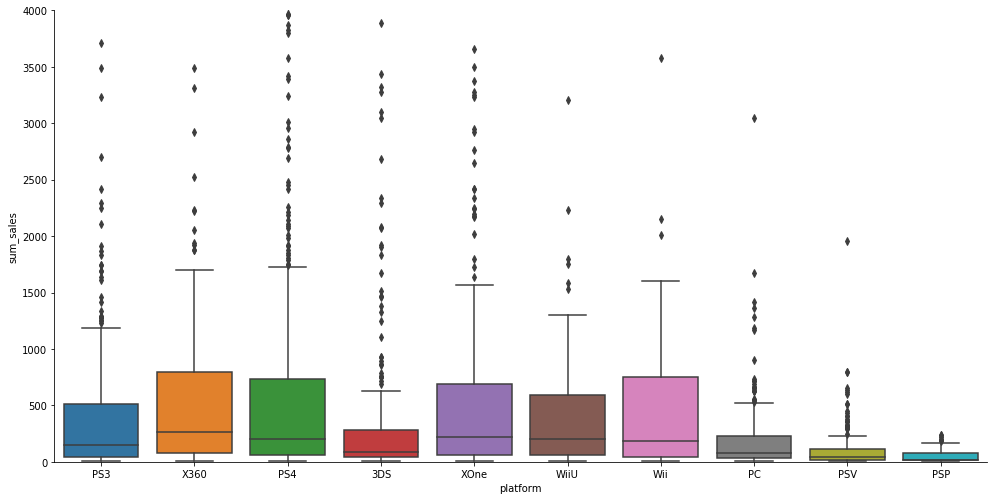

In [27]:
sns.catplot(x="platform", y="sum_sales", kind="box", data=game_rating_actual\
            ,aspect=2, height=7)
plt.ylim(0, 4000)


stat = (game_rating_actual.groupby('platform')
                       .agg({'sum_sales': ['sum','mean', 'median', 'max']})
         )

stat.T.astype('int')



Вывод: Период я брал с 2013г - сумму продаж правильно было бы определять за ровный отрезок времени. т.е. по дате последней вышедшей платформы, а это 2013г. Велика ли разница в продажах - велика. Прочные лидеры PS4, PS3, XOne, 3DS, X360. Прибыль остальных платформ на порядок ниже.

Что касается средних продаж - разница также велика. Это заслуга хитов. Медиана на этом фоне смотрится куда ровнее.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

0.3503445460228666 карреляция оценки критиков к продажам


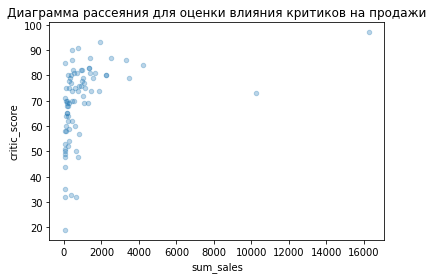

-0.011742185147181342 корреляция оценки пользователей к продажам


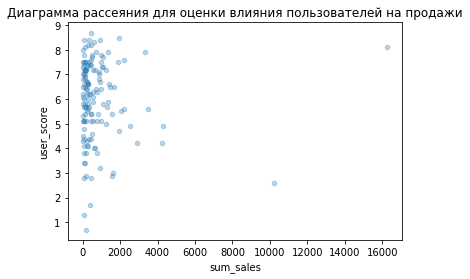

In [28]:
print(game_rating_actual.query('platform == "X360" and critic_score != -1')\
                ['critic_score'].corr(game_rating_actual['sum_sales']), 'карреляция оценки критиков к продажам')
game_rating_actual.query('platform == "X360" and critic_score != -1')\
                .plot(x='sum_sales', y='critic_score', kind='scatter', alpha=0.3,\
                     title = 'Диаграмма рассеяния для оценки влияния критиков на продажи')
plt.show()


print(game_rating_actual.query('platform == "X360" and user_score != -1')\
                ['user_score'].corr(game_rating_actual['sum_sales']),'корреляция оценки пользователей к продажам')
game_rating_actual.query('platform == "X360" and user_score != -1')\
                .plot(x='sum_sales', y='user_score', kind='scatter', alpha=0.3, \
                      title = 'Диаграмма рассеяния для оценки влияния пользователей на продажи')
plt.show()




Выводы: Влияние есть , но оно не говорит о наличии высокой связи между отзывами и продажами. Отзывы критиков влияют больше, чем отзывы пользователей. Если убрать хиты и основываться на продажах игр, не превышающих 1800 t$, то влияние критиков и пользователей на продажи возрастает. А если учитывать актуальный период с 2013 г, то взаимосвязь падает, а по отзывам пользователей становится обратной, но не значительно, фактически нулевой.

Соотнесем выводы с продажами игр на других платформах.

In [29]:
#создадим матрицу корреляции по всем параметрам одновременно.
game_rating_actual.query('critic_score >0 and user_score >0 and year_of_release >0')\
                    .pivot_table(index = 'index_game', values =['sum_sales','user_score', 'critic_score',\
                                                                           'year_of_release']).corr()

,critic_score,sum_sales,user_score,year_of_release
critic_score,1.000000,0.311230,0.502702,0.062660
sum_sales,0.311230,1.000000,-0.003964,-0.134477
user_score,0.502702,-0.003964,1.000000,0.050183
year_of_release,0.062660,-0.134477,0.050183,1.000000


Корреляция уменьшилась.  Взаимосвязь между продажами и отзывами критиков  мала. С отзывами пользователей отсутствует.

Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [48]:
#game_rating_actual['genre'].value_counts()
sum_genre = game_rating_actual.groupby(['genre'])['sum_sales'].sum().sort_values(ascending=False)

#game_rating.groupby(['genre'])['sum_sales'].sum().sort_values(ascending=False)#с учетом всех данных
#game_rating['genre'].value_counts()

In [49]:
sum_genre = pd.DataFrame({'genre':sum_genre.index, 'sum':sum_genre.values})

(-1.1118910473006058,
 1.100566240347648,
 -1.1092555360435814,
 1.1126888047037267)

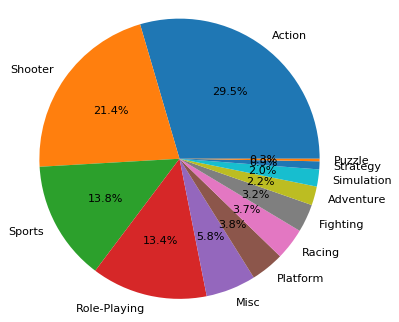

In [50]:
vals = sum_genre['sum']
labels = sum_genre['genre']
fig, ax = plt.subplots(figsize=(5, 5), dpi= 80)
ax.pie(vals, labels=labels,autopct='%1.1f%%')
ax.axis("equal")

Вывод: Действующий период - больше всего игр выпущено в жанре Action, кратно меньше в Role-Playing, Adventure, Sports и Shooter. Весь период - Action, Sports, Misc(это не определенный жанр - разное), Role-Playing , Shooter и Adventure.

Если рассматривать только актуальный период и действующие платформы - самыми прибыльными жанрами будут Action, Shooter, Sports, Role-Playing. За весь период исследования жанр Shooter переходит на третье место, а Sports на второе.

# Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):

Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [26]:
#данные в t $
#функция для вывода топ 5 платформ или жанров для региона, аргумент регион и платформа/жанр
def sort_top_5 (region,index):
      
    return game_rating_actual.pivot_table(index=[index], values = (region), aggfunc = sum).reset_index()\
                            .sort_values(ascending = False, by = region).head(5)

print(sort_top_5('na_sales','platform'))
print(sort_top_5('eu_sales','platform'))
sort_top_5('jp_sales','platform')


  platform  na_sales
3      PS4  108740.0
9     XOne   93120.0
8     X360   81660.0
2      PS3   63500.0
0      3DS   38200.0
  platform  eu_sales
3      PS4  141090.0
2      PS3   67810.0
9     XOne   51590.0
8     X360   42520.0
0      3DS   30960.0


,platform,jp_sales
0,3DS,67810.0
2,PS3,23350.0
5,PSV,18590.0
3,PS4,15960.0
7,WiiU,10880.0


In [27]:
life_platform

['PS4', 'XOne', '3DS', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV', 'PSP']

Для понимания различия в продажах по регионам, нужно понять, где какие консоли появились.
Рассмотрим только действующие на данный момент:

Япония:
Sony - PS4,PS3, PSV,PSP
Nintendo - Wii,WiiU,3DS

США:
Microsoft - X360, XOne, 

Отдельно:
PC  - производство комплектующих разбросано по всему миру, как и выпуск игр на PC.

Япония:
Почему 3DS.  Крутая фишка - 3d без очков.  упор был сделан не на графику, а на интересную фишку, узнав о которой, любой игрок захочет как минимум опробовать консоль в деле. Таких игроков оказалось много: почти миллион, только в первые два дня продаж по миру. Консоль и выпускаемые на неё игры стали хитами в Японии и в других регионах. Почему она не занимает первое мусто в других регионах, лучше почтитать тут - https://stopgame.ru/blogs/topic/64145. Если вкратце, то замкнутость на японской культуре и создала проблемы с выходом многих проектов на мировой рынок. Для японцев разборки негров из гетто так же малоинтересны, как американцам и европейцам разборки якудз с обильным пением в караоке.
Все остальные платформы из списка, тоже родом из Японии, причины все теже.

США и Европа:

Рейтинги различаются по обьему продаж каждой платформы, но не по наличию платформ в топ 5.


Самые популярные жанры (топ-5). Поясните разницу.

In [28]:
#данные в t $
print(sort_top_5('na_sales','genre'))
print(sort_top_5('eu_sales','genre'))
sort_top_5('jp_sales','genre')

           genre  na_sales
0         Action  125910.0
8        Shooter  109740.0
10        Sports   65270.0
7   Role-Playing   46400.0
3           Misc   27460.0
           genre  eu_sales
0         Action  118370.0
8        Shooter   87860.0
10        Sports   60490.0
7   Role-Playing   36970.0
6         Racing   20190.0


,genre,jp_sales
7,Role-Playing,51040.0
0,Action,40490.0
3,Misc,9440.0
2,Fighting,7650.0
8,Shooter,6610.0


Американский и Европейский геймер почти не различается в своих предпочтениях. Что не скажешь о Японском. Как писалось выше, в Японии своя культура игр.Более подробно о ней можно почитать в данной статье - https://stopgame.ru/blogs/topic/64145 И это важно ведь наш магазин продает игры и в Японию.

Влияет ли рейтинг ESRB на продажи в отдельном регионе

In [29]:
#данные в t $

ESBR = (game_rating_actual[game_rating_actual.rating != -1].groupby('rating')
                       .agg({'na_sales': ['sum'],
                            'eu_sales': ['sum'],
                            'jp_sales': ['sum']})
         )

ESBR = ESBR.T.astype('int')
ESBR['sum_sal'] = ESBR['E']+ESBR['E10+']+ESBR['M']+ESBR['T']

ESBR['E'] = (ESBR['E']/ESBR['sum_sal'])*100
ESBR['E10+'] = (ESBR['E10+']/ESBR['sum_sal'])*100
ESBR['M'] = (ESBR['M']/ESBR['sum_sal'])*100
ESBR['T'] = (ESBR['T']/ESBR['sum_sal'])*100

ESBR
#в таблице указано отношение продаж по региону к рейтингам.

,rating,E,E10+,M,T,sum_sal
na_sales,sum,22.681301,15.521204,47.491668,14.305827,348040
eu_sales,sum,26.486832,13.577015,46.544294,13.391860,313250
jp_sales,sum,27.166697,10.568814,25.318500,36.945990,55730


В Европе и Америке рейтинг ESBR влияет почти одинаково. Что не скажешь о Японии. В Японии производители предпочитают выпускать игры, которым присвоят Т(для подростков), в то время как в Европе и Америке превалирует M('Для взрослых'). Влияние рейтинга я понимаю так - если я выпущу игру, которой ESBR присвоит рейтиг M, то я отказываюсь от аудитории младше 17 лет и теряю часть выручки

# Проверьте гипотезы

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [30]:
#нулевая гипотеза -   Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

XOne = game_rating_actual[game_rating_actual.user_score != -1].query('platform == "XOne"')['user_score']
PC = game_rating_actual[game_rating_actual.user_score != -1].query('platform == "PC"')['user_score']
alpha = 0.05
game_rating_actual[game_rating_actual.user_score != -1].groupby('platform').agg({'user_score': np.var})
#дисперсия PC 2.322
#Дисперсия XOne 1.907
#Дисперсия различается не так сильно , использовать equal_var не буду.

alpha = 0.05

results = st.ttest_ind(XOne, PC)#, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.15503167687396294
Не получилось отвергнуть нулевую гипотезу


Гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Для проверки нашей гипотезы нужно было сформировать нулевую гипотезу. Поскольку в нулевой гипотезе всегда присутствует знак равенства, мы смело можем брать нашу гипотезу за нулевую. При проверке гипотезы пользовался методом, предназначенным для проверки равенства средних двух совокупностей (ind). Поскольку мне нужно было сопоставить их средние. По итогам использования метода могу сказать, что получить такие данные в рамках нулевой гипотезы маловероятно. Данные подтверждают вероятность того, средние пользовательские рейтинги платформ Xbox One и PC различается.

Средние пользовательские рейтинги жанров Action  и Sports разные.

In [31]:
#нулевая гипотеза -   Средние пользовательские рейтинги жанров Action  и Sports равны.

action = game_rating_actual[game_rating_actual.user_score != -1].query('genre == "Action"')['user_score']
sports = game_rating_actual[game_rating_actual.user_score != -1].query('genre == "Sports"')['user_score']
alpha = 0.05
game_rating_actual[game_rating_actual.user_score != -1].groupby('genre').agg({'user_score': np.var})
#дисперсия Action 2.027
#Дисперсия Sports 2.620
#Дисперсия различается ,возможно, стоит  использовать equal_var.

alpha = 0.05

results = st.ttest_ind(action, sports, equal_var=False)#применение equal_var почти не поменяло значения p-value, соответственно 
#и итоговые выводы

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0898071807865848e-20
Отвергаем нулевую гипотезу


Гипотеза - средние пользовательские рейтинги жанров Action и Sports разные. Формируем нулевую гипотезу - средние пользовательские рейтинги жанров Action и Sports равны. Использовал тот же метод, что и при проверке первой гипотезы. По итогам использования метода могу сказать, что данные НЕ протеворечат НУЛЕВОЙ гипотезе. Соответственно, можно предположить, что средние пользовательские рейтинги жанра Action возможно НЕ отличается от пользовательские рейтинги жанра Sports.

Дополнительные расчеты

Строил таблицу с дублированными играми на разных платформах. Чтобы провести сравнение, как одна и та же игра продается на разных платформах. Не реализовал до конца.

In [34]:
doubles = game_rating_actual['name'].value_counts().reset_index()
doubles = doubles.query('name >=2')
doubles = doubles['index'].tolist()
doubles_games = game_rating_actual.query('name == @doubles')
doubles_games.groupby(['name', 'platform'])['sum_sales'].sum().reset_index().groupby('platform')['sum_sales'].sum()

platform
3DS      19830.0
PC       27700.0
PS3     164710.0
PS4     279450.0
PSP       1680.0
PSV      19180.0
Wii      13610.0
WiiU     22490.0
X360    134480.0
XOne    135090.0
Name: sum_sales, dtype: float64

О значимости экстримальных значений в ненормальном распределении.

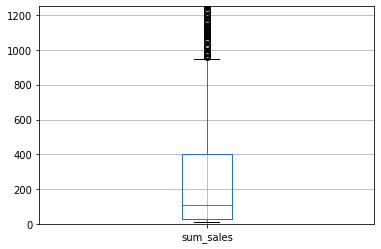

547320.0

In [35]:
game_rating_actual.boxplot(column = 'sum_sales')
plt.ylim(0,1250)
plt.show()
#что мы видим по графику - все , что выше 950 т $ это экстремальные значения.

top_game_sales = game_rating_actual.query('sum_sales > 1900').groupby('name')['sum_sales'].sum().\
                                        reset_index().sort_values(by = 'sum_sales', ascending=False)
#сделал таблицу игр суммарная прибыль, которых составила минимум в два раза больше, чем значение верхнего "уса"


(len(top_game_sales)/len(doubles))*100 #18,64 % 
game_rating_actual['sum_sales'].sum()# сумма продаж всех игр за актуальный период 1090020$
top_game_sales['sum_sales'].sum()#547320$

#88 игр принесли 547320$, а значит, что 18,64 % приносят чуть больше 50 % всей выручки.
#Возможно, стоило изучать подробно именно эти игры и платформы, на которых они выпускались.
#но на это у меня уже не хватило времени, возможно, чуть позже я попробую переделать часть работы и её выводы.

Идея с линейкой игр на примере Grand Theft Auto. По таблице видно, что данная игра вседа приносит хорошую прибыль.
Идея в том , что игроки любят и ждут продолжения уже понравившийся им игры. На этом можно зарабатывать.

In [36]:
game_rating[game_rating['name'].str.contains('Grand Theft Auto')].sort_values(by='year_of_release', ascending=False)\
                                .query('platform == "PS4" or platform == "PS3" or platform == "PS2" or platform == "PS"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales,index_game
42,Grand Theft Auto V,PS4,2014,Action,3960.0,6310.0,380.0,1970.0,97.0,8.3,M,12620.0,42
16,Grand Theft Auto V,PS3,2013,Action,7020.0,9090.0,980.0,3960.0,97.0,8.2,M,21050.0,16
57,Grand Theft Auto IV,PS3,2008,Action,4760.0,3690.0,440.0,1610.0,98.0,7.5,M,10500.0,57
2122,Grand Theft Auto: Vice City Stories,PS2,2007,Action,780.0,30.0,30.0,130.0,75.0,7.9,M,970.0,2121
363,Grand Theft Auto: Liberty City Stories,PS2,2006,Action,1560.0,1400.0,70.0,500.0,78.0,7.8,M,3530.0,363
17,Grand Theft Auto: San Andreas,PS2,2004,Action,9430.0,400.0,410.0,10570.0,95.0,9.0,M,20810.0,17
1034,Rockstar Games Double Pack: Grand Theft Auto I...,PS2,2003,Action,850.0,660.0,0.0,220.0,-1.0,-1.0,-1,1730.0,1033
24,Grand Theft Auto: Vice City,PS2,2002,Action,8410.0,5490.0,470.0,1780.0,95.0,8.7,M,16150.0,24
38,Grand Theft Auto III,PS2,2001,Action,6990.0,4510.0,300.0,1300.0,97.0,8.5,M,13100.0,38
389,Grand Theft Auto 2,PS,1998,Action,1130.0,2070.0,0.0,220.0,70.0,8.0,T,3420.0,389


# Общий вывод

Проанализировав данные из предоставленной выборки, я пришел к следующим выводам:


Для успешной работы нашего магазина и для наиболее рентабельного распределения рекламных бюджетов для каждой игры, следует обращать внимания на то:

1 Как долго существует платформа, на которой выпускается игра. Как показал анализ, среднее время существования платформы - 11-12 лет. И к концу жизненого цикла платформы, продажи на ней падают. Своего пика на платформе продажи достигают к 4 -6 году от появления. К тому времени, как продажи начинают падать, производители стараются выпускать новые платформы.  
В первый год продажи на новых платвормах сравнительно невелики. Но есть и исключения, например 3DS и Wii от Nintendo. Их популярность связана с инновационными решениями. Появление беспроводного контроллера, реагирующего на движение игрока в Wii и 3d дисплей в 3DS. Стоит обращать внимание на инновации в производстве платформ.
Рост по продажам на данный момент показывает две платформы - 'PS4', 'XOne'. Третий флагман от Nintendo WiiU  падает по продажам, он вышел чуть раньше конкурентов.
Прочные лидеры по суммам продаж -  PS4, PS3, XOne, 3DS, X360.
Обязательно нужно помнить о национальной составляющей платформ. Для японцев разборки негров из гетто так же малоинтересны, как американцам и европейцам разборки якудз с обильным пением в караоке. Но грани по некоторым играм размываются. Например Final Fantasy X.

2 Влияние отзывов на продажи игры
Отзывы критиков влияют на продажи, но говорить о наличии высокой связи между отзывами и продажами не стоит.
Отзывы пользователей не влияют на продажи. Есть игры с отличными отзывами, но с уровнем продаж, как у игр почти с нулевыми отзывами. Резюмируя - нашему магазину стоит обращать внимание на отзывы критиков, но не увлекаясь. 

3 Жанры
Есть топовые жанры, продажи которых превышают все другие -  Action, Shooter, Sports, Role-Playing. Но поскольку мы продаем игры по всему миру ( я надеюсь, у нас есть сайт на японском) нужно обратить внимание, что топ жанров в Японии отличается от остальных регионов.

4 Рейтиг ESRB 
В Европе и Америки больше всего игр покупается с рейтингом М(для взрослых), в то время , как в Японии это Т(Подросткам). 
Нужно учитывать это и ориентироваться при выборе игры для запуска рекламы.


Хотелось добавить ещё несколько выводов, возникших при работе с данными:

Магазину следует учесть, какие в прошлом были хиты продаж:
88 игр принесли 547320$, а значит, что 18,64 % игр  приносят чуть больше 50 % всей выручки.
Возможно, стоило изучать подробно именно эти игры и платформы, на которых они выпускались.
но на это у меня уже не хватило времени, возможно чуть позже я попробую переделать часть работы и её выводы.
Но из этого уже можно сделать выводы, что при выходе продолжения игры, которая была ранее популярна, стоит на него обратить внимание.
Чего только стоила серия FIFA,GTA или Mario)

Следить за инновациями в области платформ. Яркий пример Wii , с своей Wii Sports.

И тут мы приходим к основной идеи по поводу прибыльности игр и ставки на них. Сегмент производства игр относится к масштабируемым. И определить с большой вероятностью популярность выходящей игры сложно. Какая игра завтра станет хитом(при условии, что это не продолжение популярной линейки)? Это не известно. Мы можем сказать только, что у какой-то игры шансов стать хитом мало.